# EDA 

* Data from [WiDS Datathon 2021](https://www.kaggle.com/c/widsdatathon2021)

* Objective: To determine whether a patient admitted to an Intensive Care Unit (ICU) has been diagonsed with a particular type of diabetes, Diabetes Mellitus, using data from the first 24 hours of intensive care.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set3')
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})
import warnings
warnings.filterwarnings("ignore") # ignore plot warning messages
from ipywidgets import interact   # interactive plot
from scipy import stats # unpaired t-test

# Modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, recall_score

In [2]:
# Import training data
train = pd.read_csv("../data/TrainingWiDS2021.csv", index_col=0)
test = pd.read_csv("../data/UnlabeledWiDS2021.csv", index_col=0)

print(train.shape)
print(test.shape)

train.head()

(130157, 180)
(10234, 179)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


### Which is the target (label) column to predict?

In [3]:
target = [col for col in train.columns if col not in test.columns]
target

['diabetes_mellitus']

<AxesSubplot:xlabel='diabetes_mellitus', ylabel='count'>

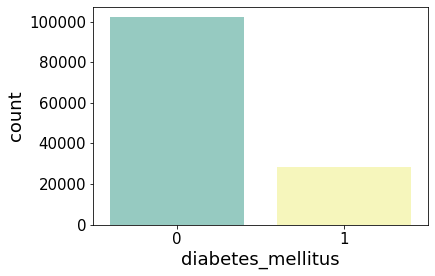

In [4]:
# Count targets
sns.countplot(train['diabetes_mellitus'])

* Unbalanced binary target distribution

## 1. Training data quality check

In [5]:
# Missing rows (just check, don't do anything yet)
prop_isnull = train.isnull().mean()
prop_isnull = prop_isnull[prop_isnull > 0]
prop_isnull

age                     0.038323
bmi                     0.034497
ethnicity               0.012193
gender                  0.000507
height                  0.015958
                          ...   
h1_arterial_ph_min      0.828607
h1_arterial_po2_max     0.825503
h1_arterial_po2_min     0.825503
h1_pao2fio2ratio_max    0.871232
h1_pao2fio2ratio_min    0.871232
Length: 160, dtype: float64

* 160 out of 180 columns have missing information, number of missing records ranging between 3.8 - 87.1%

In [6]:
# Duplicated rows
train[train.duplicated() == True]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


* No duplicated rows

## 2. Data distribution

In [7]:
# Data types
train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [8]:
# Separate data by binary, categorical, continous types

# Binary
two_unique_values = (train.nunique().values == 2) # find columns # unique value equals 2
binary = train.loc[:,two_unique_values] # select columns
binary = binary.loc[:, ~binary.isna().any()] # remove columns containing nulls

# Categorical & continuous
non_binaries = [col for col in train.columns if col not in binary.columns]
train_non_bi = train[non_binaries]
categoricals = train_non_bi.select_dtypes(include=["object"])
continuous = train_non_bi.select_dtypes(exclude=["object"])

print(binary.shape)
print(categoricals.shape)
print(continuous.shape)

(130157, 13)
(130157, 6)
(130157, 161)


## 2-1. Binary variables

In [9]:
# Missing data?
binary.isnull().mean()

elective_surgery               0.0
apache_post_operative          0.0
arf_apache                     0.0
intubated_apache               0.0
ventilated_apache              0.0
aids                           0.0
cirrhosis                      0.0
hepatic_failure                0.0
immunosuppression              0.0
leukemia                       0.0
lymphoma                       0.0
solid_tumor_with_metastasis    0.0
diabetes_mellitus              0.0
dtype: float64

* No missing rows

In [10]:
binary.drop('diabetes_mellitus', axis=1, inplace=True)
binary.shape

(130157, 12)

In [11]:
# Interactive plot to check distribution of binary variables
@interact(cols=binary.columns)
def get_countplot_binary(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Print normalized counts of each variable
    print(binary[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

In [12]:
# Interactive plot to check relationships
# between the binary variables and the target variable
@interact(cols=binary.columns)
def get_countplot_diabetes(cols):
    plt.figure(figsize=(12,6))
    sns.countplot(x=cols, hue='diabetes_mellitus', data=train)
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    plt.legend(bbox_to_anchor=(1.15, 1))
    
    # Print normalized counts of each variable
    print(train.groupby('diabetes_mellitus')[cols].value_counts(normalize=True).round(2))
    
    # This part is for categorical vaviables below
    # Rotate the xlabels if more than 4 values available
    if train[cols].nunique() > 4:
         plt.xticks(rotation=40)

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

### Highlights of binary data

**arf_apache**
* When there was no diabetes: positive 2 %
* When there was diabetes: positive 6 %

    * *APACHE*: Acute Physiology and Chronic Health Evaluation II score to predict hospital mortality

## 2-2. Categorical variables

In [13]:
# Missing data per each column
categoricals.isnull().mean()

ethnicity                0.012193
gender                   0.000507
hospital_admit_source    0.255061
icu_admit_source         0.001844
icu_stay_type            0.000000
icu_type                 0.000000
dtype: float64

* 25% of the observations lack their hospital_admit_source

In [14]:
# Interactive plot to check distribution of categorical variables
@interact(cols=categoricals.columns)
def get_countplot_cat(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Rotate the xlabels if more than 4 values available
    if categoricals[cols].nunique() > 4:
         plt.xticks(rotation=40)
            
    # Print normalized counts of each variable
    print(categoricals[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

### Highlights of categorical data

**Ethnity**
* Highly unbalanced ratial distribution: Majority of the data (~78%) is from Caucasians.

**Gender**
* Slightly more male samples(54%) than the females (46%)

**Hospital admit source**
* More than 52% from Emergercy Department. (Remember, 25% of the patients lack this information)

**ICU admit source**
* Over 59% of patients admitted to ICU after Accident & Emergency

**ICU stay type**
* Most(95%) of the patients stay admitted to the unit, ~4% transferred to other locations, <1% readmitted

**ICU type**
* ~55% of the patients in Med-Surg ICU (=Medical Surgical Intensive Care Unit)

In [15]:
# Interactive plot to check relationships
# between the categorical variables and the target variable
interact(get_countplot_diabetes, cols=categoricals.columns)

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

<function __main__.get_countplot_diabetes(cols)>

**Ethnity**
* Regardless of ethnity, 20-30 % of the patients from the data had diabetes mellitus

**Gender**
* In both sexes, 21-22 % of the patiens had diabetes mellitus

**Hospital admit source, ICU admit source, ICU stay type, ICU type**
* Similar to ethnity, roughly 20-30 % of each group had diabetes mellitus

**icu_admit_source and icu_type**
* Slight changes in order of frequency when compared negative vs. positive to diabetes mellitus

## 2-3. Continuous variables

In [16]:
# Interactive plot to check distribution of continuous variables

# Excude ids from plot
except_ids = [col for col in continuous.columns if col[-2:] != 'id']

# Histograms to show distribution of continuous values
@interact(cols=except_ids)
def get_histplot(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.histplot(continuous[cols])
    
    plt.axvline(continuous[cols].median(), color='red')  # Median in red
    plt.axvline(continuous[cols].mean(), color='green')  # Mean in green
    
    print('Mean: ', round(continuous[cols].mean(), 1))
    print('Median: ', round(continuous[cols].median(), 1))

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [17]:
# Interactive relplot between continuous variables and the target variable
@interact(cols=except_ids + ['diabetes_mellitus'])
def get_boxplot(cols):
    plt.figure(figsize=(12,6))
    sns.boxplot(x=train['diabetes_mellitus'], y=train[cols])
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    
    # Print normalized counts of each variable
    count_diabetes = train.groupby('diabetes_mellitus')[cols].count()
    print('Total counts: ', count_diabetes.sum())
    print(' ')
    print(count_diabetes)
    print(' ')
    
    # Print mean values
    diabetes = train['diabetes_mellitus'] == 1
    positive = train[diabetes][cols]
    negative = train[~diabetes][cols]
    print('No diabetes meallitus(0)', negative.mean())
    print('Diabetes meallitus(1)', positive.mean())

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [18]:
# Calculate ttest and print only the columns with significant difference
diabetes = train['diabetes_mellitus'] == 1
significant_cols = []

for col in continuous.columns:
    positive = continuous[diabetes][col]
    negative = continuous[~diabetes][col]
    tstats , p_value = stats.ttest_ind(negative.values, positive.values, nan_policy='omit')

    if p_value < 0.05:
        significant_cols.append(col)
        
print(len(significant_cols))
print(significant_cols[:5])

133
['age', 'bmi', 'icu_id', 'pre_icu_los_days', 'weight']


### Highlight of continous data

**Significant difference between groups**
* 133 out of 161 columns including age, bmi, pre_icu_los_days, weight.

In [19]:
# Highly linearly correlated continuous variable?
cols_for_corr = significant_cols + ['diabetes_mellitus']
corr = train[cols_for_corr].corr()['diabetes_mellitus'].sort_values()
corr

h1_diasbp_invasive_min   -0.103672
h1_diasbp_invasive_max   -0.088664
h1_hco3_max              -0.086883
h1_hco3_min              -0.086548
d1_diasbp_invasive_min   -0.084994
                            ...   
h1_glucose_min            0.304520
h1_glucose_max            0.316847
glucose_apache            0.354359
d1_glucose_max            0.400742
diabetes_mellitus         1.000000
Name: diabetes_mellitus, Length: 134, dtype: float64

In [20]:
# heatmap?

# 3. Data cleaning + Feature engineering

In [157]:
train_new = train.copy()
test_new = test.copy()

print(train_new.shape)
print(test_new.shape)

(130157, 180)
(10234, 179)


In [158]:
train_new = train_new.sort_values('encounter_id')
test_new = test_new.sort_values('encounter_id')

train_new.set_index('encounter_id', inplace=True)
test_new.set_index('encounter_id', inplace=True)

print(train_new.shape)
print(test_new.shape)
train_new.head()

(130157, 179)
(10234, 178)


,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
encounter_id,,,,,,,,,,,,,,,,,,,,,
147000,163,73.0,28.727377,1,Caucasian,M,182.90,NaN,Operating Room / Recovery,1082,...,NaN,NaN,0,0,0,0,0,0,0,0
147001,159,NaN,24.925526,0,Other/Unknown,M,162.60,NaN,Accident & Emergency,709,...,NaN,NaN,0,0,0,0,0,0,0,0
147002,40,43.0,25.118065,0,Caucasian,M,175.20,Emergency Department,Accident & Emergency,636,...,NaN,NaN,0,0,0,0,0,0,0,0
147003,202,35.0,24.838934,0,Caucasian,M,172.72,Emergency Department,Accident & Emergency,427,...,NaN,NaN,0,0,0,0,0,0,0,0
147004,171,59.0,24.389348,1,Other/Unknown,F,165.00,Operating Room,Operating Room / Recovery,404,...,NaN,NaN,0,0,0,0,0,0,1,0


Let's plot the current columns to decide imputation methods

In [159]:
@interact(col=train_new.columns)
def another_plot(col):
    plt.figure(figsize=(14,6))
    if col in continuous.columns:
        train_new.groupby('diabetes_mellitus')[col].hist()
    else:
        sns.countplot(x=col, hue='diabetes_mellitus', data=train_new)

interactive(children=(Dropdown(description='col', options=('hospital_id', 'age', 'bmi', 'elective_surgery', 'e…

* Type 2 diabetes is an adult-onset metabolic disease linked with excessive body weight, insufficient exercise
    * related columns: age, height-weight, bmi
    * ethnity (Excess body fat is associated with 30% of cases in Chinese and Japanese descent, 60–80% of cases in those of European and African descent, and 100% of Pima Indians and Pacific Islanders)

<br>

* High blood sugar level -> 'Hyperglycemia': an excessive amount of glucose circulates in the blood plasma.
    * glucose-apache, d1_glucose_max, d1_glucose_min

In [160]:
# age >= 18 -> adult?
# bmi >= 30 -> obesity

def get_obese_adult(df):
    df['bmi'] = np.log(df['bmi'])
    df['weight'] = np.log(df['weight'])
    
    df['obese_peril'] = df['age'] * df['bmi']
    df['height_weight_ratio'] = df['weight'] / df['height']
    
    # new column with squared bmi
    df['bmi_2'] = df['bmi'].apply(lambda x: x*x)

get_obese_adult(train_new)
get_obese_adult(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 182)
(10234, 181)


In [161]:
# Normal daily glucose level max: 7.8  min: 4 mmol/L
# (ref: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html)
def abnormal_glucose(df):
    df['glucose_apache'] = df['glucose_apache'].apply(lambda x: x*x)
    df['d1_glucose_max'] = df['d1_glucose_max'].apply(lambda x: np.log(x))
    df['d1_glucose_min'] = df['d1_glucose_min'].apply(lambda x: np.log(x))
    df['d1_glucose_peril'] = df['d1_glucose_max'] / df['d1_glucose_min']


abnormal_glucose(train_new)
abnormal_glucose(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 183)
(10234, 182)


In [162]:
def metrics_renal(df):
    df['bun_apache'] = df['bun_apache'].apply(lambda x: np.log(x))
    df['creatinine_apache'] = df['creatinine_apache'].apply(lambda x: np.log(x))
    df['d1_bun_max'] = df['d1_bun_max'].apply(lambda x: np.log(x))
    df['d1_creatinine_max'] = df['d1_creatinine_max'].apply(lambda x: np.log(x))
    df['metrics_renal'] = df['bun_apache'] * df['creatinine_apache'] + df['arf_apache']
    df['bun_creatinine'] = df['d1_bun_max'] * df['d1_creatinine_max'] - df['d1_bun_min'] * df['d1_creatinine_min']
    
# albumin?
# high levels of albumin is one of several indicators of chronic kidney disease (CKD), a common complication of both type 1 and type 2 diabetes

metrics_renal(train_new)
metrics_renal(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 185)
(10234, 184)


In [163]:
def metrics_gcs(df):
    df['metrics_gcs'] = df['gcs_motor_apache'] * df['gcs_eyes_apache']
    df['gcs_verbal_apache'] = df['gcs_verbal_apache'].apply(lambda x: x*x)

metrics_gcs(train_new)
metrics_gcs(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 186)
(10234, 185)


In [164]:
def metrics_heart(df):    
    # Hemoglobin and diabetes: add wikipedia link
    df['metrics_hemoglobin'] = (df['d1_hemaglobin_max'] / df['d1_hemaglobin_min'])
    
    sysbp = [f for f in df.columns if f[3:8] == 'sysbp']
    df['metrics_sysbp'] = df[sysbp].sum(axis=1)
    diasbp = [f for f in df.columns if f[3:9] == 'diasbp']
    df['metrics_diasbp'] = df[diasbp].sum(axis=1)
    
    # In hypertensive diabetes mellitus, lower K & lower Ca & higher Na can be observed
    # https://pubmed.ncbi.nlm.nih.gov/18488152/
    # Hypertension: systolic > 129 mmHg or diastolic > 79 mmHg
    df['d1_sysbp_max_2'] = df['d1_sysbp_max'].apply(lambda x: x*x)
    d1_systolic_avg = df[['d1_sysbp_max', 'd1_sysbp_min']].mean(axis=1) > 129
    d1_diastolic_avg = df[['d1_diasbp_max', 'd1_diasbp_min']].mean(axis=1) > 79
    hypertensive = [d1_systolic_avg | d1_diastolic_avg]
    df['hypertensive'] = hypertensive[0]*1

metrics_heart(train_new)
metrics_heart(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 191)
(10234, 190)


In [165]:
def possible_dka(df):
# diabetic ketoacidosis (DKA): disturbance of the mechanisms to maintain blood pH
# an acute and life-threatening complication of the chronic metabolic disease
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC151994/

# normal anion gap: Na+ – (Cl– + HCO3–) = 12 mmol/L
# In DKA, anion gap increased & the sum of bicarbonate and chloride concentrations is reduced
    df['metrics_sodium'] = df['d1_sodium_max'] / df['d1_sodium_min']
    
# Also, arterial pH reduces (<=7.30)
    acidic_blood_gas = df[['d1_arterial_ph_max', 'd1_arterial_ph_min']].mean(axis=1) <= 7.30
    df['possible_DKA'] = acidic_blood_gas*1

# Increased potassium, lactate
    df['metrics_potassium'] = df['d1_potassium_max'] / df['d1_potassium_min']

possible_dka(train_new)
possible_dka(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 194)
(10234, 193)


In [166]:
def metrics_liver(df):
    df['metrics_liver'] = df['cirrhosis'] * df['hepatic_failure']
    df['bilirubin_2'] = np.log(train_new['bilirubin_apache']).apply(lambda x: x*x)

metrics_liver(train_new)
metrics_liver(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 196)
(10234, 195)


In [167]:
def metrics_immune(df):
    df['wbc_apache'] = np.log(df['wbc_apache'])
    immune_cols = ['wbc_apache', 'immunosuppression', 'leukemia', 'lymphoma']
    df['metrics_immune'] = df[immune_cols].sum(axis=1)
    
metrics_immune(train_new)
metrics_immune(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 197)
(10234, 196)


In [168]:
# Let's drop some columns of which the majority are empty rows
# First, examine the proportion of empty values of each column
prop_nulls = train_new.isnull().mean()
prop_nulls[-30:]

h1_arterial_po2_max            0.825503
h1_arterial_po2_min            0.825503
h1_pao2fio2ratio_max           0.871232
h1_pao2fio2ratio_min           0.871232
aids                           0.000000
cirrhosis                      0.000000
hepatic_failure                0.000000
immunosuppression              0.000000
leukemia                       0.000000
lymphoma                       0.000000
solid_tumor_with_metastasis    0.000000
diabetes_mellitus              0.000000
obese_peril                    0.071329
height_weight_ratio            0.034497
bmi_2                          0.034497
d1_glucose_peril               0.063331
metrics_renal                  0.196901
bun_creatinine                 0.107409
metrics_gcs                    0.016826
metrics_hemoglobin             0.124711
metrics_sysbp                  0.000000
metrics_diasbp                 0.000000
d1_sysbp_max_2                 0.002082
hypertensive                   0.000000
metrics_sodium                 0.101954


In [169]:
# Let's say we drop the entire rows of columns of which >=30% are empty
# since those will be hard to be imputed in the future
less_than_30perc = prop_nulls[prop_nulls < 0.3]
cols_to_keep = list(less_than_30perc.index)# + ['possible_DKA', 'd1_lactate_avg', 'bilirubin_2']
train_new = train_new[cols_to_keep]
test_new = test_new[[c for c in test_new.columns if c in cols_to_keep]]

print(train_new.shape)
print(test_new.shape)

(130157, 122)
(10234, 121)


In [171]:
# Let's impute the rest of the empty values
def fill_nas(df):
    for col in df.columns:
        df[col] = df[col].transform(lambda x: x.fillna(x.mode()[0]))
        
fill_nas(train_new)
fill_nas(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 122)
(10234, 121)


In [172]:
def ethnicity_icutype(df):
    df['ethnicity_icutype'] = df[['ethnicity', 'icu_type']].apply(lambda x: ''.join(x), axis=1)
    
ethnicity_icutype(train_new)
ethnicity_icutype(test_new)

print(train_new.shape)
print(test_new.shape)

(130157, 123)
(10234, 122)


In [173]:
# Convert string (categorical) values into numbers using dummies
train_new = pd.get_dummies(train_new, drop_first=True, dtype='int64')
test_new = pd.get_dummies(test_new, drop_first=True, dtype='int64')
print(train_new.shape)
print(test_new.shape)

(130157, 196)
(10234, 190)


In [176]:
train_new = train_new.dropna()
test_new = test_new.dropna()

print(train_new.shape)
print(test_new.shape)

(130157, 196)
(10234, 190)


# 3. Modeling

### XGBoost

In [177]:
corr_cols = list(train_new.corr()['diabetes_mellitus'].sort_values().index[-180:])

In [178]:
cols_to_remove = ['readmission_status', 'hospital_id']

In [179]:
# Split the data into train and test sets for supervised learning.
# Define features and the target

final_features = [c for c in test_new.columns if (c not in cols_to_remove)]# and (c in corr_cols)]
test_final = test_new[final_features]
X = train_new[final_features]
y = train_new['diabetes_mellitus']

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(91109, 188)
(39048, 188)
(91109,)
(39048,)


In [200]:
xgb = XGBClassifier(scale_pos_weight=15, learning_rate=0.08, min_child_weight=6,
                    n_estimators=300, max_depth=5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08, max_delta_step=0, max_depth=5,
              min_child_weight=6, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=15, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# crossvalidation

<Figure size 720x720 with 0 Axes>

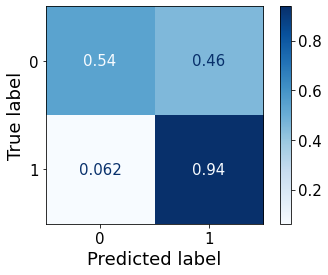

In [201]:
# Predict values
y_prediction_xgb = xgb.predict(X_test)

# Plot a confusion matrix using test sets
plt.figure(figsize=(10,10))
confusion_matrix = plot_confusion_matrix(xgb, X_test, y_test,
                                         cmap='Blues', normalize='true')
plt.grid(False)

Recall score: 0.9382481924854806


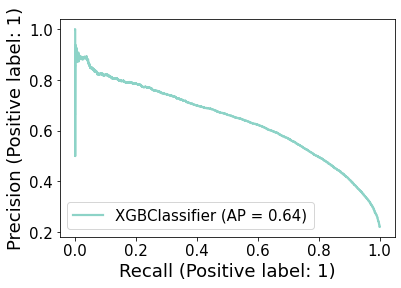

In [202]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)***

recall_base = recall_score(y_test, y_prediction_xgb)
print(f'Recall score: {recall_base}')

base_precision_recall = plot_precision_recall_curve(xgb, X_test, y_test)
base_precision_recall

In [203]:
print(classification_report(y_test, y_prediction_xgb))

              precision    recall  f1-score   support

           0       0.97      0.54      0.69     30611
           1       0.36      0.94      0.52      8437

    accuracy                           0.63     39048
   macro avg       0.67      0.74      0.61     39048
weighted avg       0.84      0.63      0.66     39048



In [ ]:
break

In [ ]:
import lightgbm as lgb
lgbm = 
lgmb.fit(X_train, y_train)
y_prediction_lgbm = lgbm.predict(X_test)

In [ ]:
# Plot a confusion matrix using test sets
plt.figure(figsize=(10,10))
confusion_matrix = plot_confusion_matrix(lgbm, X_test, y_test,
                                         cmap='Blues', normalize='true')
plt.grid(False)

In [ ]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)***

recall_lgbm = recall_score(y_test, y_prediction_lgbm)
print(f'Recall score: {recall_lgbm}')

base_precision_recall = plot_precision_recall_curve(lgbm, X_test, y_test)
base_precision_recall

In [ ]:
print(classification_report(y_test, y_prediction_lgbm))

# 4. Submission

In [204]:
pred_real_test = xgb.predict_proba(test_final)[:,1]
pred_real_test

array([0.7531422 , 0.1443838 , 0.51736534, ..., 0.6479153 , 0.69098365,
       0.92158544], dtype=float32)

In [205]:
template = pd.read_csv("../submissions/SolutionTemplateWiDS2021.csv")
template.head()

,encounter_id,diabetes_mellitus
0,135000,NaN
1,135001,NaN
2,135002,NaN
3,135003,NaN
4,135004,NaN


In [206]:
template['diabetes_mellitus'] = pd.Series(pred_real_test)
template.head()

,encounter_id,diabetes_mellitus
0,135000,0.753142
1,135001,0.144384
2,135002,0.517365
3,135003,0.846544
4,135004,0.041688


In [207]:
template.isnull().sum()

encounter_id         0
diabetes_mellitus    0
dtype: int64

In [208]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Diabetes Mellitus Predictions 42.csv'

template.to_csv(f'../submissions/{filename}', index=False)

print('Saved file: ' + filename)

Saved file: Diabetes Mellitus Predictions 42.csv
